In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Đường dẫn Kaggle
CSV_PATH = "/kaggle/input/misshanooi/Impute_misvalues_hanoi.csv"
print("📂 Dataset path:", CSV_PATH)


📂 Dataset path: /kaggle/input/misshanooi/Impute_misvalues_hanoi.csv


In [7]:
def compute_features(x):
    """Rút trích đặc trưng hình dạng cơ bản."""
    x = np.asarray(x)
    mean = np.mean(x)
    std = np.std(x)
    skew = stats.skew(x) if len(x) > 2 else 0
    kurt = stats.kurtosis(x) if len(x) > 3 else 0
    rng = np.ptp(x)
    return np.array([mean, std, skew, kurt, rng])

def fast_dtw_cost(a, b, radius=3):
    """DTW nhanh có giới hạn Sakoe-Chiba window."""
    n, m = len(a), len(b)
    radius = max(radius, abs(n - m))
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n + 1):
        j_start, j_end = max(1, i - radius), min(m, i + radius)
        for j in range(j_start, j_end + 1):
            cost = abs(a[i - 1] - b[j - 1])
            dtw[i, j] = cost + min(dtw[i - 1, j], dtw[i, j - 1], dtw[i - 1, j - 1])
    return dtw[n, m]

def find_gaps(series):
    """Xác định vị trí và độ dài các đoạn missing (NaN)."""
    gaps = []
    is_nan = np.isnan(series)
    i = 0
    while i < len(series):
        if is_nan[i]:
            j = i
            while j < len(series) and is_nan[j]:
                j += 1
            gaps.append((i, j - i))
            i = j
        else:
            i += 1
    return gaps


In [8]:
def edtwbi_fast(series, T_min=10, cosine_thres=0.85, sakoe=4, verbose=False):
    """
    eDTWBI (Enhanced Dynamic Time Warping Based Imputation) phiên bản nhanh.
    - Tìm đoạn tương tự nhất với vùng trước gap dựa vào cosine + DTW.
    - Điền đoạn missing bằng giá trị tương ứng từ đoạn tương tự.
    """
    s = np.array(series, dtype=float)
    ref = s.copy()
    n = len(s)
    result = s.copy()
    gaps = find_gaps(s)
    info = []

    for (start, length) in gaps:
        T = max(T_min, length)
        left = s[max(0, start - T):start]

        if len(left) < 3:
            fill = np.nanmean(ref)
            result[start:start + length] = fill
            info.append((start, length, "fallback-short"))
            continue

        candidates = []
        step = max(1, T // 2)
        for i in range(0, n - T, step):
            seg = ref[i:i + T]
            if np.any(np.isnan(seg)):
                continue
            f1, f2 = compute_features(left), compute_features(seg)
            cos = cosine_similarity([f1], [f2])[0][0]
            if cos > cosine_thres:
                dist = fast_dtw_cost(left, seg, radius=sakoe)
                candidates.append((i, dist))

        if len(candidates) == 0:
            fill = np.nanmean(ref)
            result[start:start + length] = fill
            info.append((start, length, "fallback-no-match"))
            continue

        candidates.sort(key=lambda x: x[1])
        pos = candidates[0][0]
        fill_start = pos + T
        if fill_start + length <= n:
            fill = ref[fill_start:fill_start + length]
        else:
            fill = np.full(length, np.nanmean(ref))
        result[start:start + length] = fill
        info.append((start, length, "eDTWBI"))

        if verbose:
            print(f"Filled gap {start}:{length} → eDTWBI")

    return result, info


In [9]:
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

def nmae(y, yhat):
    vmax, vmin = np.nanmax(y), np.nanmin(y)
    denom = vmax - vmin if vmax != vmin else 1
    return np.mean(np.abs(y - yhat)) / denom

def similarity(y, yhat):
    vmax, vmin = np.nanmax(y), np.nanmin(y)
    denom = vmax - vmin if vmax != vmin else 1
    return np.mean(1 / (1 + np.abs(y - yhat) / denom))

def frac_bias(y, yhat):
    my, mx = np.mean(yhat), np.mean(y)
    denom = (my + mx) if (my + mx) != 0 else 1
    return 2 * abs(my - mx) / denom


In [10]:
# Load dữ liệu
df = pd.read_csv(CSV_PATH)

# Sử dụng cột Average (bị missing thật)
if "Average" in df.columns:
    target_col = "Average"
else:
    target_col = df.select_dtypes(include=[np.number]).columns[0]

series = pd.to_numeric(df[target_col], errors="coerce").values

print(f"🔹 Cột sử dụng: {target_col}")
print(f"Độ dài: {len(series)} | Missing: {np.isnan(series).sum()}")

# Phân tích gap
gaps = find_gaps(series)
avg_gap = np.mean([g[1] for g in gaps]) if gaps else 5
print("Trung bình độ dài gap:", round(avg_gap, 2))

# Chọn tham số tự động
T_min = int(min(20, max(5, avg_gap * 1.5)))
cosine_thres = 0.85 if len(series) < 2000 else 0.9
sakoe = 4 if avg_gap < 10 else 6

print(f"⚙️ Tham số tự động: T_min={T_min}, cosine_thres={cosine_thres}, sakoe={sakoe}")


🔹 Cột sử dụng: Average
Độ dài: 29224 | Missing: 25910
Trung bình độ dài gap: 7.82
⚙️ Tham số tự động: T_min=11, cosine_thres=0.9, sakoe=4


Số điểm đánh giá hợp lệ: 165 / 1461

📊 KẾT QUẢ ĐÁNH GIÁ (trên vùng missing nhân tạo 5%):
RMSE       : 169.6236
MAE        : 127.7566
NMAE       : 0.169439
Similarity : 0.866390
FracBias   : 0.066624


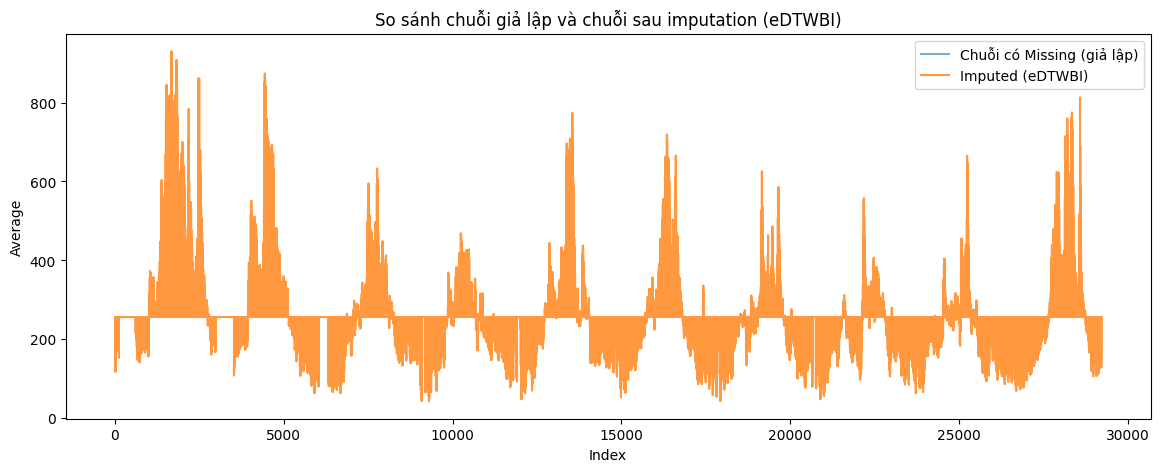

In [14]:
# 📊 Cell 7 — Đánh giá eDTWBI trên vùng missing nhân tạo (5%)

# 1️⃣ Copy chuỗi gốc
true_series = series.copy()

# 2️⃣ Tạo 5% vị trí missing giả định
rng = np.random.default_rng(42)
mask_missing = rng.choice(len(series), size=int(0.05 * len(series)), replace=False)
series_with_missing = series.copy()
series_with_missing[mask_missing] = np.nan

# 3️⃣ Chạy eDTWBI
imputed, info = edtwbi_fast(series_with_missing, T_min=T_min, cosine_thres=cosine_thres, sakoe=sakoe)

# 4️⃣ Đánh giá chỉ tại vị trí missing nhân tạo
mask_eval = mask_missing
y_true = true_series[mask_eval]
y_pred = imputed[mask_eval]

# 🧹 Loại bỏ NaN còn sót
valid_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true = y_true[valid_mask]
y_pred = y_pred[valid_mask]

print(f"Số điểm đánh giá hợp lệ: {len(y_true)} / {len(mask_eval)}")

# 5️⃣ In kết quả
if len(y_true) > 0:
    print("\n📊 KẾT QUẢ ĐÁNH GIÁ (trên vùng missing nhân tạo 5%):")
    print(f"RMSE       : {rmse(y_true, y_pred):.4f}")
    print(f"MAE        : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"NMAE       : {nmae(y_true, y_pred):.6f}")
    print(f"Similarity : {similarity(y_true, y_pred):.6f}")
    print(f"FracBias   : {frac_bias(y_true, y_pred):.6f}")
else:
    print("⚠️ Không đủ điểm hợp lệ để tính metric (toàn NaN)")

# 6️⃣ Vẽ biểu đồ
plt.figure(figsize=(14,5))
plt.plot(series_with_missing, label="Chuỗi có Missing (giả lập)", alpha=0.6)
plt.plot(imputed, label="Imputed (eDTWBI)", alpha=0.8)
plt.legend()
plt.title("So sánh chuỗi giả lập và chuỗi sau imputation (eDTWBI)")
plt.xlabel("Index")
plt.ylabel(target_col)
plt.show()


In [15]:
from itertools import product
import time

T_min_list = [8, 12, 15]
cosine_list = [0.85, 0.90]
sakoe_list = [4, 6]

results = []
start_all = time.time()

print(" Bắt đầu GridSearch...\n")


true_series = series.copy()
rng = np.random.default_rng(42)
mask_missing = rng.choice(len(series), size=int(0.05 * len(series)), replace=False)
series_with_missing = series.copy()
series_with_missing[mask_missing] = np.nan


for (T_min, cosine_thres, sakoe) in product(T_min_list, cosine_list, sakoe_list):
    t0 = time.time()
    imputed, _ = edtwbi_fast(series_with_missing, T_min=T_min, cosine_thres=cosine_thres, sakoe=sakoe)
    
    # Đánh giá
    y_true = true_series[mask_missing]
    y_pred = imputed[mask_missing]
    valid_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true, y_pred = y_true[valid_mask], y_pred[valid_mask]

    if len(y_true) == 0:
        continue

    res = {
        "T_min": T_min,
        "cosine_thres": cosine_thres,
        "sakoe": sakoe,
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "NMAE": nmae(y_true, y_pred),
        "Similarity": similarity(y_true, y_pred),
        "FracBias": frac_bias(y_true, y_pred),
        "Time (s)": round(time.time() - t0, 2)
    }
    results.append(res)
    print(f" Done: {res}")

print(f"\n Tổng thời gian GridSearch: {round(time.time() - start_all, 2)} giây")


df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Similarity", ascending=False).reset_index(drop=True)

print("\n BẢNG KẾT QUẢ GRIDSEARCH:")
display(df_results.style.background_gradient(subset=["Similarity", "RMSE"], cmap="RdYlGn_r").format(precision=4))


best = df_results.iloc[0]
print(" Best configuration:")
print(f"T_min={best.T_min}, cosine_thres={best.cosine_thres}, sakoe={best.sakoe}")
print(f"→ RMSE={best.RMSE:.4f}, Similarity={best.Similarity:.4f}, Time={best['Time (s)']}s")


 Bắt đầu GridSearch...

 Done: {'T_min': 8, 'cosine_thres': 0.85, 'sakoe': 4, 'RMSE': 169.62360163834808, 'MAE': 127.7566471318456, 'NMAE': 0.1694385240475406, 'Similarity': 0.8663896813921843, 'FracBias': 0.06662368443713361, 'Time (s)': 97.25}
 Done: {'T_min': 8, 'cosine_thres': 0.85, 'sakoe': 6, 'RMSE': 169.62360163834808, 'MAE': 127.7566471318456, 'NMAE': 0.1694385240475406, 'Similarity': 0.8663896813921843, 'FracBias': 0.06662368443713361, 'Time (s)': 97.75}
 Done: {'T_min': 8, 'cosine_thres': 0.9, 'sakoe': 4, 'RMSE': 169.62360163834808, 'MAE': 127.7566471318456, 'NMAE': 0.1694385240475406, 'Similarity': 0.8663896813921843, 'FracBias': 0.06662368443713361, 'Time (s)': 96.11}
 Done: {'T_min': 8, 'cosine_thres': 0.9, 'sakoe': 6, 'RMSE': 169.62360163834808, 'MAE': 127.7566471318456, 'NMAE': 0.1694385240475406, 'Similarity': 0.8663896813921843, 'FracBias': 0.06662368443713361, 'Time (s)': 97.41}
 Done: {'T_min': 12, 'cosine_thres': 0.85, 'sakoe': 4, 'RMSE': 169.62360163834808, 'MAE': 

,T_min,cosine_thres,sakoe,RMSE,MAE,NMAE,Similarity,FracBias,Time (s)
0,8,0.8500,4,169.6236,127.7566,0.1694,0.8664,0.0666,97.2500
1,8,0.8500,6,169.6236,127.7566,0.1694,0.8664,0.0666,97.7500
2,8,0.9000,4,169.6236,127.7566,0.1694,0.8664,0.0666,96.1100
3,8,0.9000,6,169.6236,127.7566,0.1694,0.8664,0.0666,97.4100
4,12,0.8500,4,169.6236,127.7566,0.1694,0.8664,0.0666,65.4400
5,12,0.8500,6,169.6236,127.7566,0.1694,0.8664,0.0666,65.4200
6,12,0.9000,4,169.6236,127.7566,0.1694,0.8664,0.0666,65.2000
7,12,0.9000,6,169.6236,127.7566,0.1694,0.8664,0.0666,64.6800
8,15,0.8500,4,169.6236,127.7566,0.1694,0.8664,0.0666,56.3700
9,15,0.8500,6,169.6236,127.7566,0.1694,0.8664,0.0666,56.4200


 Best configuration:
T_min=8.0, cosine_thres=0.85, sakoe=4.0
→ RMSE=169.6236, Similarity=0.8664, Time=97.25s
